In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [40]:
from tensorflow import keras

In [41]:
### only run once! sets up working directory to be /quality_issue_predictor
import os
os.chdir(os.getcwd()[:-34] + r'\quality_issue_predictor') 

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\steven.hansen01\\OneDrive - Cardinal Heal\\quality_issue_predictor'

### Purpose:
Generate a model using only the archived shop order data set.  
Why:
    Because currently the shop order data does not intersect with the plantstar data yet.  Using only shop order potentially increases the training size 5-fold from previous model.

In [42]:
archived_df = pd.read_csv('./clean_data/archived_so.csv')
archived_df = archived_df.drop(columns = 'Unnamed: 0')
ncs_df = pd.read_csv('./clean_data/NCs.csv')

In [43]:
archived_df.head()


,Shop Order,Component,MRdate,MQISS,Product,BOM qty,MOPNO,Finished qty,MQREQ,Requested qty,Lot Number,Date
0,186151,RM129,20190422,57534.048,V8536,20.592,20,2794.0,57451.68,2790.0,18M09063,2019-04-22
1,186151,RM093,20190422,0.000,V8536,0.000,20,2794.0,0.00,2790.0,18M09063,2019-04-22
2,186151,RM160,20190422,0.000,V8536,0.000,20,2794.0,0.00,2790.0,18M09063,2019-04-22
3,182831,FS10017466,20190901,0.000,8881907102,0.000,0,120.0,0.00,120.0,18C16263X,2019-09-01
4,182831,EXP6021,20190901,0.000,8881907102,0.000,0,120.0,0.00,120.0,18C16263X,2019-09-01


In [44]:

print(archived_df.shape)

(73239, 12)


### One-Hot encoding everything


In [45]:
#remove formula sheets (probably no value)
archived_df = archived_df[(archived_df['Component'].str.contains('FS')==False) & (archived_df['Component'].str.contains('DC')==False)]\
                .reset_index(drop=True)
archived_df.shape

(63698, 12)

In [46]:
archived_df.head()

,Shop Order,Component,MRdate,MQISS,Product,BOM qty,MOPNO,Finished qty,MQREQ,Requested qty,Lot Number,Date
0,186151,RM129,20190422,57534.048,V8536,20.592,20,2794.0,57451.68,2790.0,18M09063,2019-04-22
1,186151,RM093,20190422,0.000,V8536,0.000,20,2794.0,0.00,2790.0,18M09063,2019-04-22
2,186151,RM160,20190422,0.000,V8536,0.000,20,2794.0,0.00,2790.0,18M09063,2019-04-22
3,182831,EXP6021,20190901,0.000,8881907102,0.000,0,120.0,0.00,120.0,18C16263X,2019-09-01
4,182831,PT00004155,20190901,0.000,8881907102,0.000,0,120.0,0.00,120.0,18C16263X,2019-09-01


In [47]:
%%time
df = pd.DataFrame()
for lot, frame in archived_df.groupby('Lot Number'):
    df.loc[lot,frame['Product'].unique()[0]] = 1
    for i,comp in enumerate(frame['Component']):
        frame = frame.reset_index(drop = True)
        if frame.loc[i,'BOM qty']>0:
            df.loc[lot,comp] = 1
df.head()

Wall time: 43.4 s


,8881907102,8881112059,85121,WP8510,RM171,R1246D,R4415,CL63R9869A,PT00006610,8934,...,8612U,RM160,RM157,PT00103021,R7616,8902GSTC,PT00096237,R7032N,RM169,PT00104295
18C16263X,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18C16363X,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18C16463X,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18E20563X,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18E20663X,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
df =df.fillna(0).reset_index().rename(columns = {'index':'Lot Number'})

In [49]:
print(df.shape)

(5012, 535)


In [50]:
df.head()

,Lot Number,8881907102,8881112059,85121,WP8510,RM171,R1246D,R4415,CL63R9869A,PT00006610,...,8612U,RM160,RM157,PT00103021,R7616,8902GSTC,PT00096237,R7032N,RM169,PT00104295
0,18C16263X,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18C16363X,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,18C16463X,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18E20563X,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18E20663X,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
%%time
for i, lot in enumerate(df['Lot Number']):
    if lot in ncs_df['Lot Number'].unique():
        df.loc[i,'NC'] = 1
    else:
        df.loc[i,'NC'] = 0

Wall time: 2.68 s


In [52]:
sum(df.NC)

586.0

In [53]:
df.head()

,Lot Number,8881907102,8881112059,85121,WP8510,RM171,R1246D,R4415,CL63R9869A,PT00006610,...,RM160,RM157,PT00103021,R7616,8902GSTC,PT00096237,R7032N,RM169,PT00104295,NC
0,18C16263X,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18C16363X,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,18C16463X,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18E20563X,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18E20663X,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
X = df.iloc[:,1:-1]

In [55]:
y = df.iloc[:,-1]

In [56]:
sum(y)/len(X)

0.1169193934557063

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42)

In [59]:
X_train.shape

(3358, 534)

In [60]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [61]:
rng = np.random.RandomState(1)
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=15, random_state=rng)

In [62]:
%%time
ada_reg.fit(X_train,y_train)

Wall time: 695 ms


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=15,
                  random_state=RandomState(MT19937) at 0x1A3B6971040)

In [63]:
y_1 = ada_reg.predict(X_test)

In [64]:
from sklearn.metrics import precision_recall_curve


In [65]:
precision, recall, thresholds = precision_recall_curve(y_test,y_1)

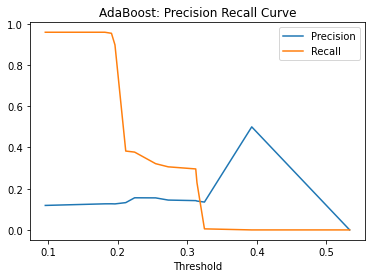

In [66]:
plt.plot(thresholds,precision[:-1],label = 'Precision')
plt.plot(thresholds,recall[1:],label = 'Recall')
plt.title('AdaBoost: Precision Recall Curve')
plt.xlabel('Threshold')
plt.legend()
plt.show()

In [67]:
recall[1:]

array([0.95918367, 0.95918367, 0.95408163, 0.89795918, 0.38265306,
       0.37755102, 0.32142857, 0.30612245, 0.29591837, 0.22959184,
       0.00510204, 0.        , 0.        ])

In [68]:
precision[:-1]

array([0.11885992, 0.12659933, 0.12677006, 0.12626604, 0.1324304 ,
       0.15592516, 0.15546218, 0.14482759, 0.14218009, 0.14009662,
       0.13513514, 0.5       , 0.        ])

In [69]:
thresholds

array([0.09625247, 0.18181818, 0.19126506, 0.1962963 , 0.21177945,
       0.22454484, 0.25471698, 0.27272727, 0.3123053 , 0.31405313,
       0.32480903, 0.39271925, 0.53333333])

In [70]:
print(5*'-'+' Balanced Precision and Recall Model '+5*'-')
test_threshold = np.round(0.39271925,4)
print(f'percent of lots indicted = {round(100*len(y_1[y_1>=test_threshold])/len(y_1),2)}%')
print(f'recall (NC reduction) = {round(100*recall[np.where(np.round(thresholds,4) == test_threshold)][0],2)}%')
print(f'total number of predicted NCs = {len(y_1[y_1>=test_threshold])}')
print('True Positives = ')
print(f'precision = {round(100*precision[np.where(np.round(thresholds,4) == test_threshold)][0],2)}%')

----- Balanced Precision and Recall Model -----
percent of lots indicted = 0.12%
recall (NC reduction) = 0.51%
total number of predicted NCs = 2
True Positives = 
precision = 50.0%


In [71]:
sum(y_test.iloc[np.where(y_1>0.23076923)[0]])/len(np.where(y_1>0.23076923)[0])

0.15546218487394958

In [72]:
df.isnull().sum(axis=0)

Lot Number    0
8881907102    0
8881112059    0
85121         0
WP8510        0
             ..
PT00096237    0
R7032N        0
RM169         0
PT00104295    0
NC            0
Length: 536, dtype: int64

In [73]:
X_test.iloc[np.where(y_1>0.19)[0]]

,8881907102,8881112059,85121,WP8510,RM171,R1246D,R4415,CL63R9869A,PT00006610,8934,...,8612U,RM160,RM157,PT00103021,R7616,8902GSTC,PT00096237,R7032N,RM169,PT00104295
4871,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2894,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4392,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2610,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2186,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
sum(y_test.iloc[np.where(y_1>0.19)[0]])

188.0

In [75]:
X_test

,8881907102,8881112059,85121,WP8510,RM171,R1246D,R4415,CL63R9869A,PT00006610,8934,...,8612U,RM160,RM157,PT00103021,R7616,8902GSTC,PT00096237,R7032N,RM169,PT00104295
4871,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2894,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4392,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2610,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2186,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
precision[np.where(np.round(thresholds,4) == test_threshold)]

array([0.5])

In [81]:
'21F10563' in df['Lot Number']

False

In [82]:
all_components = set(archived_df.Component)

In [83]:
resins = set()
for component, frame in archived_df.groupby(by = 'Component'):
    if component[0:2] == 'RM':
        resins.add(component)
print(resins)
print(len(resins))

{'RM031', 'RM220', 'RM093', 'RM026', 'RM106', 'RM129', 'RM157', 'RM054', 'RM176', 'RM154', 'RM260', 'RM160', 'RM168', 'RM074', 'RM171', 'RM025', 'RM004', 'RM112', 'RM170', 'RM169', 'RM032', 'RM201', 'RM020', 'RM165', 'RM070'}
25


In [84]:
PTcomponents = set()
for component, frame in archived_df.groupby(by = 'Component'):
    if component[0:2] == 'PT':
        PTcomponents.add(component)
print(PTcomponents)
print(len(PTcomponents))

{'PT00069525', 'PT00047930', 'PT00006673', 'PT00052518', 'PT00034377', 'PT00067912', 'PT00055216', 'PT00006682', 'PT00068803', 'PT00048792', 'PT00049845', 'PT00052701', 'PT00065939', 'PT00055730', 'PT00006674', 'PT00046145', 'PT00034301', 'PT00005153', 'PT00015857', 'PT00096202', 'PT00067917', 'PT00006643', 'PT00068808', 'PT00068806', 'PT00006688', 'PT00068805', 'PT00103021', 'PT00013694', 'PT00006651', 'PT00009994', 'PT00104295', 'PT00033971', 'PT00075580', 'PT00013702', 'PT00015840', 'PT00005525', 'PT00006610', 'PT00016498', 'PT00006657', 'PT00016490', 'PT00033972', 'PT00013699', 'PT00006671', 'PT00012138', 'PT00034305', 'PT00044733', 'PT00006672', 'PT00062563', 'PT00005527', 'PT00046937', 'PT00033502', 'PT00065936', 'PT00004155', 'PT00006653', 'PT00033501', 'PT00062605', 'PT00067914', 'PT00096177', 'PT00013696', 'PT00013707', 'PT00033969', 'PT00013692', 'PT00012252', 'PT00006655', 'PT00006677', 'PT00006659', 'PT00044728', 'PT00005149', 'PT00034294', 'PT00033970', 'PT00049846', 'PT00

In [85]:
FScomponents = set()
for component, frame in archived_df.groupby(by = 'Component'):
    if component[0:2] == 'FS':
        FScomponents.add(component)
print(FScomponents)
print(len(FScomponents))

set()
0


In [86]:
CLcomponents = set()
for component, frame in archived_df.groupby(by = 'Component'):
    if component[0:2] == 'CL':
        CLcomponents.add(component)
print(CLcomponents)
print(len(CLcomponents))

{'CL63R98407A', 'CL63R98338', 'CL63R1784', 'CL63R1776', 'CL63R1706', 'CL63R98173', 'CL63R1779', 'CL63R9881A', 'CL63R1796', 'CL63R1783', 'CL63RR98416', 'CL63R1146', 'CL63R1794', 'CL63R98474A', 'CL63R98234', 'CL63R98334A', 'CL63R98337A', 'CL63R9962A', 'CL63R1040', 'CL63R1778', 'CL63R3908', 'CL63R9870B', 'CL63R1773', 'CL63R1771', 'CL63R98461A', 'CL63R9828', 'CL63R98226', 'CL63R1653', 'CL63R1654', 'CL63R1770A', 'CL63R1780', 'CL63R9960A', 'CL63R98355', 'CL63R9876B', 'CL63R1767A', 'CL63R1782', 'CL63R9869A', 'CL63R4153', 'CL63R1603', 'CL63R1769B', 'CL63R98346', 'CL63R98396A', 'CL63R1777', 'CL63R1774', 'CL63R98211', 'CL63R1781', 'CL63R98482', 'CL63R4445', 'CL63R1768B'}
49


In [87]:
Rcomponents = set()
for component, frame in archived_df.groupby(by = 'Component'):
    if (component[0] == 'R') & (component[1]!='M'):
        Rcomponents.add(component)
print(Rcomponents)
print(len(Rcomponents))

{'R5104', 'R1317D', 'R98350', 'R1626A', 'R1748', 'R7642B', 'R1246D', 'R8930LA', 'R8550', 'R1378B', 'R1057', 'R1800', 'R4395', 'R4226A', 'R1292D', 'R1306D', 'R1333D', 'R9249D', 'R7089W-1', 'R1293D', 'R2000', 'R1749', 'R1705', 'R3712', 'R7417', 'R1644A', 'R1750', 'R8550LGB', 'R98027', 'R1680', 'R1158', 'R9242D', 'R7421BL', 'R9806', 'R7626', 'R1075', 'R98399A', 'R1681', 'R1474', 'R98179', 'R4237', 'R1308D', 'R5098', 'R9801', 'R1300D', 'R7408', 'R1694', 'R1338D', 'R7028MW', 'R1704', 'R7013', 'R5097', 'R9366D', 'R7545', 'R1481B', 'R7472', 'R98405B', 'R1594', 'R1690', 'R7637', 'R7046MW', 'R1635A', 'R1035', 'R1697', 'R98028', 'R1695', 'R1025D', 'R98190', 'R98184', 'R8534', 'R1528A', 'R1324D', 'R98034', 'R7616', 'R1149', 'R98180', 'R98189', 'R1700', 'R7028NMW', 'R1320D', 'R1073D', 'R8554B', 'R8516-1HB', 'R1160D', 'R8535', 'R7611', 'R1565B', 'R1693', 'R1698', 'R4415', 'R1471B', 'R1156C', 'R1741', 'R1679', 'R1302D', 'R1567', 'R7027MW'}
97


In [88]:
WPcomponents = set()
for component, frame in archived_df.groupby(by = 'Component'):
    if component[0:2] == 'WP':
        WPcomponents.add(component)
print(WPcomponents)
print(len(WPcomponents))

{'WP7450BL', 'WP8965U', 'WP8982', 'WP0001PKG', 'WP8510', 'WP8836PNB', 'WP8860', 'WP8965N', 'WP851201N', 'WP7409', 'WP8986', 'WP8998', 'WP7478', 'WP7445', 'WP7102', 'WP0002PKG', 'WP7483', 'WP7417BLNB', 'WP0003PKG', 'WP7417', 'WP8825', 'WP4810', 'WP8965MW', 'WP8999', 'WP8964', 'WP8980-C', 'WP3206', 'WP8520N', 'WP8985', 'WP7029N', 'WP7605', 'WP8850', 'WP8998P', 'WP7450', 'WP7417BL', 'WP3204', 'WP7026P', 'WP7418', 'WP8520N02', 'WP8836P', 'WP8512U', 'WP8935', 'WP8920', 'WP7450BLNB', 'WP8526', 'WP8979', 'WP7477', 'WP7026', 'WP7449', 'WP7417P', 'WP8520U', 'WP8540', 'WP7024K'}
53


In [89]:
all_components.difference(FScomponents.union(PTcomponents,resins,CLcomponents,Rcomponents,WPcomponents))

{'0301001',
 '0301009',
 '0400145',
 '0420650',
 '3154021',
 '3201413',
 '4001204',
 '4001801',
 '4006202',
 '4101801',
 '4220125',
 '4230505',
 '4500906',
 '4502575',
 '5000109',
 '5000231',
 '5030483',
 '5151171',
 '5170114',
 '5170406',
 '5170588',
 '5170969',
 '5241005',
 '5241006',
 '5241008',
 '5241008R',
 '5500148',
 '5500149',
 '5510301',
 '5510320',
 '5510509',
 '5542735',
 '7777129656',
 '8507SA',
 'CM285160000',
 'CM285160071',
 'EXP1020',
 'EXP5001',
 'EXP5013',
 'EXP5050',
 'EXP6001',
 'EXP6020',
 'EXP6021',
 'EXP6026',
 'EXP6027',
 'EXP6029',
 'X98140',
 'X98141',
 'X98142',
 'X98146',
 'X98151',
 'X9894',
 'X9898',
 'X9899',
 'X9901'}

In [90]:
archived_df[archived_df['Component'] == '8507SA']

,Shop Order,Component,MRdate,MQISS,Product,BOM qty,MOPNO,Finished qty,MQREQ,Requested qty,Lot Number,Date
2924,188686,8507SA,20190619,69.00,8556H,0.05,20,1380.0,69.00,1380.0,19E16463,2019-06-19
3668,189187,8507SA,20190910,68.40,8556H,0.05,20,1360.0,68.40,1368.0,19G02063,2019-09-10
9868,193921,8507SA,20201013,0.00,8556H,0.05,20,1151.0,57.10,1142.0,20H13263,2020-10-13
19358,188515,8507SA,20190717,69.00,8556H,0.05,20,1449.0,69.00,1380.0,19E08563,2019-07-17
20861,189966,8507SA,20191015,69.00,8556H,0.05,20,1439.0,69.00,1380.0,19H24463,2019-10-15
25521,191573,8507SA,20200602,96.60,8556H,0.05,20,1932.0,96.60,1932.0,20A20463,2020-06-02
32785,187131,8507SA,20190313,0.00,8556H,0.05,20,1256.0,58.65,1173.0,19B22363,2019-03-13
34286,187945,8507SA,20190524,6.40,8556H,0.05,20,128.0,6.40,128.0,19C25863,2019-05-24
38957,190827,8507SA,20200206,72.00,8556H,0.05,20,1412.0,70.60,1412.0,19L10163,2020-02-06
43491,193774,8507SA,20200915,100.05,8556H,0.05,20,2001.0,100.05,2001.0,20H01963,2020-09-15


In [91]:
parts = pd.read_csv(open('./reference_data/parts.csv',encoding = "ISO-8859-1"))
parts = parts[['Number','Description - Long','Lifecycle Phase']][parts['Lifecycle Phase'] == 'Active']\
        .reset_index(drop=True)

In [92]:
for i, description in enumerate(parts['Description - Long']):
    if 'Resin' in description:
        parts.loc[i,'component_type'] = 'Resin'
    if 'Colorant' in description:
        parts.loc[i,'component_type'] = 'Colorant'
    if ('Plunger' in description) or ('PLGR' in description):
        parts.loc[i,'component_type'] = 'Plunger'
    if 'Barrel' in description:
        parts.loc[i,'component_type'] = 'Barrel'
    if ('Videojet' in description) or ('INK'in description.upper()) or ('PAD PRINT' in description.upper()) :
        parts.loc[i,'component_type'] = 'Ink related'
    if ('PURGING' in description.upper()):
        parts.loc[i,'component_type'] = 'Ink related'
    if ('RUBBER TIP' in description.upper()):
        parts.loc[i,'component_type'] = 'Rubber Tip'
    if 'Lid, Scoop, and Door Assembly' in description:
        parts.loc[i,'component_type'] = 'Lid'
    if 'Gasketed Lid' in description:
        parts.loc[i,'component_type'] = 'Lid'
    if 'LID' in description.upper():
        parts.loc[i,'component_type'] = 'Lid'
    if 'Sleeve' in description:
        parts.loc[i,'component_type'] = 'Sleeve'
    if 'COWL & LID' in description:
        parts.loc[i,'component_type'] = 'Lid'
    if 'DOOR' in description.upper():
        parts.loc[i,'component_type'] = 'lid'
    if ('CAP' in description.upper()) and ('SNAP' in description.upper()):
        parts.loc[i,'component_type'] = 'lid'
    if ('CAP' in description.upper()) and ('CHEMO' in description.upper()):
        parts.loc[i,'component_type'] = 'lid'
    

In [93]:
parts[parts['component_type'].isna()]

,Number,Description - Long,Lifecycle Phase,component_type
2,301006,POLYPRO 7824MR,Active,NaN
20,3156002,412 Syringe Assembly Phantom,Active,NaN
37,4220104,"Printing Foil for Hot Stamp Marking, 2.375 Inc...",Active,NaN
38,4220125,"Print Tape, Black, 3 Inch Wide, B215SL",Active,NaN
41,4500005,"Finished Component, MONOJECT 500E Hooded Needl...",Active,NaN
...,...,...,...,...
612,WP7477,Chemotherapy Hood with Printed Instruction Lab...,Active,NaN
613,WP7477NB,"Pharmaceutical, Non Hazardous, Non Biohazard, ...",Active,NaN
619,WP7596,PRINTED TUMBLER FOR GATORGUARD,Active,NaN
667,X9902,"Polybag, 13 Inch x 10 Inch",Active,NaN


In [ ]:
def test_word(word):
    for i, description in enumerate(parts['Description - Long']):
        if word in description:
            print(parts.iloc[i])
test_word('CAP')

In [78]:
for comp in all_components:
    if (comp[0:2] == 'FS') or (comp[0:2]=='DC'):
        continue
    if len(parts[parts['Number'] == comp]) == 0:
        print(comp)

NameError: name 'all_components' is not defined